In [1]:
import jax

import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np

from dcegm.interface import policy_for_state_choice_vec
from dcegm.pre_processing.setup_model import setup_model
from dcegm.solve import (
    get_solve_func_for_model,
)

from toy_models.cons_ret_model_dcegm_paper.utility_functions_log_crra import (
    utiility_log_crra,
    utiility_log_crra_final_consume_all,
)
from toy_models.load_example_model import load_example_models

# set the jax_enable_x64 configuration option
jax.config.update("jax_enable_x64", True)

In [2]:
# model_name = "retirement_no_taste_shocks"

# params = {
#     "beta"                : 0.95,       # discount factor
#     "delta"               : 0.35,       # disutility of work
#     "rho"                 : 1.95,       # CRRA coefficient
#     "constant"            : 0.75,       # age-independent labor income
#     "exp"                 : 0.04,       # return to experience
#     "exp_squared"         : -0.0002,    # return to experience squared
#     "sigma"               : 0.00,       # shock on labor income sigma parameter/standard deviation
#     "lambda"              : 2.2204e-16, # taste shock (scale) parameter
#     "interest_rate"       : 0.05,       # interest rate on capital
#     "initial_wealth_low"  : 0,          # lowest level of initial wealth (relevant for simulation)
#     "initial_wealth_high" : 30,         # highest level of initial wealth (relevant for simulation)
#     "max_wealth"          : 50,         # maximum level of wealth
#     "consumption_floor"   : 0.001,      # consumption floor/retirement safety net (only relevant in the dc-egm retirement model)
# }

# model_specs = {
#     "n_periods"                    : 25,  # number of periods
#     "min_age"                      : 20,  # minimum age
#     "n_discrete_choices"           : 2,   # number of discrete choices
#     "n_grid_points"                : 500, # number of grid points
#     "max_wealth"                   : 50,  # maximum level of wealth
#     "quadrature_points_stochastic" : 5,   # number of quadrature points for stochastic integration
#     "n_simulations"                : 10,  # number of simulations
# }

In [3]:
model_name = "retirement_taste_shocks"

params = {
    "beta": 0.98,  # discount factor
    "delta": 1.00,  # disutility of work
    "rho": 2.00,  # CRRA coefficient
    "constant": 1.0,  # age-independent labor income
    "exp": 0.00,  # return to experience
    "exp_squared": 0.00,  # return to experience squared
    "sigma": 0.07,  # shock on labor income sigma parameter/standard deviation
    "lambda": 0.2,  # taste shock (scale) parameter
    "interest_rate": 0.02,  # interest rate on capital
    "initial_wealth_low": 0,  # lowest level of initial wealth (relevant for simulation)
    "initial_wealth_high": 10,  # highest level of initial wealth (relevant for simulation)
    "max_wealth": 30,  # maximum level of wealth
    "consumption_floor": 0.001,  # consumption floor/retirement safety net (only relevant in the dc-egm retirement model)
}

model_specs = {
    "n_periods": 44,  # number of periods
    "min_age": 20,  # minimum age
    "n_discrete_choices": 2,  # number of discrete choices
    "n_grid_points": 1000,  # number of grid points
    "max_wealth": 30,  # maximum level of wealth
    "quadrature_points_stochastic": 15,  # number of quadrature points for stochastic integration
    "n_simulations": 10,  # number of simulations
}

In [4]:
# model_name = "deaton"

# params = {
#     "beta"                : 0.95,       # discount factor
#     "delta"               : 0,          # disutility of work
#     "rho"                 : 1,          # CRRA coefficient
#     "constant"            : 0.75,       # age-independent labor income
#     "exp"                 : 0.04,       # return to experience
#     "exp_squared"         : -0.0004,    # return to experience squared
#     "sigma"               : 0.25,       # shock on labor income sigma parameter/standard deviation
#     "lambda"              : 2.2204e-16, # taste shock (scale) parameter
#     "interest_rate"       : 0.05,       # interest rate on capital
#     "initial_wealth_low"  : 0,          # lowest level of initial wealth (relevant for simulation)
#     "initial_wealth_high" : 30,         # highest level of initial wealth (relevant for simulation)
#     "max_wealth"          : 75,         # maximum level of wealth
#     "consumption_floor"   : 0.0,        # consumption floor/retirement safety net (only relevant in the dc-egm retirement model)
# }

# model_specs = {
#     "n_periods"                    : 25,  # number of periods
#     "min_age"                      : 20,  # minimum age
#     "n_discrete_choices"           : 1,   # number of discrete choices
#     "n_grid_points"                : 100, # number of grid points
#     "max_wealth"                   : 75,  # maximum level of wealth
#     "quadrature_points_stochastic" : 10,  # number of quadrature points for stochastic integration
#     "n_simulations"                : 10,  # number of simulations
# }

In [5]:
options = {}
options["model_params"] = model_specs
options["model_params"]["n_choices"] = model_specs["n_discrete_choices"]
options["state_space"] = {
    "n_periods": model_specs["n_periods"],
    "choices": [i for i in range(model_specs["n_discrete_choices"])],
    "continuous_states": {
        "wealth": jnp.linspace(
            0,
            options["model_params"]["max_wealth"],
            options["model_params"]["n_grid_points"],
        )
    },
}

model_funcs = load_example_models("dcegm_paper")

if model_name == "deaton":
    model_funcs["state_space_functions"] = None
    model_funcs["utility_functions"]["utility"] = utiility_log_crra
    model_funcs["final_period_utility_functions"][
        "utility"
    ] = utiility_log_crra_final_consume_all

model = setup_model(
    options=options,
    state_space_functions=model_funcs["state_space_functions"],
    utility_functions=model_funcs["utility_functions"],
    utility_functions_final_period=model_funcs["final_period_utility_functions"],
    budget_constraint=model_funcs["budget_constraint"],
)

# the solve func will solve the model for a given dictionary of parameters
solve_func = get_solve_func_for_model(model)

Update function for state space not given. Assume states only change with an increase of the period and lagged choice.
Sparsity condition not provided. Assume all states are valid.
Starting state space creation
State space created.

Starting state-choice space creation and child state mapping.
State, state-choice and child state mapping created.

Start creating batches for the model.
The batch size of the backwards induction is  3
Model setup complete.



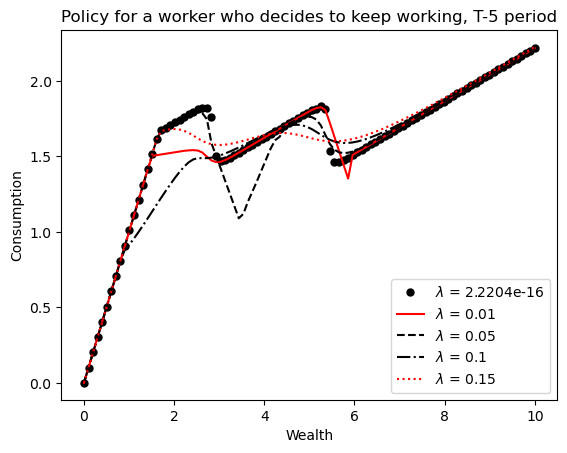

In [7]:
line_styles = [
    {
        "color": "black",
        "marker": "o",
        "linestyle": "None",
        "markersize": 5,
    },  # Scatter black dots
    {"color": "red", "linestyle": "-"},  # Red solid line
    {"color": "black", "linestyle": "--"},  # Black dashed line
    {"color": "black", "linestyle": "-."},  # Black dash-dot line
    {"color": "red", "linestyle": ":"},  # Red dotted line
]

for idx, taste_shock_scale in enumerate([2.2204e-16, 0.01, 0.05, 0.10, 0.15]):
    # Set the taste shock scale and solve the model
    params["lambda"] = taste_shock_scale
    value, policy, endog_grid = solve_func(params)

    # Look at the consumption policy for T-5 period, for a worker who decides to keep working (choice=0)
    test_period = (
        options["state_space"]["n_periods"] - 6
    )  # T-5 period since we are 0-indexed
    state_choice_dict = {
        "period": test_period,
        "lagged_choice": 0,
        "dummy_exog": 0,
        "choice": 0,
    }
    # Set wealth grid for plotting
    wealth_grid = np.linspace(0, 10, 100)

    # Compute consumption policy for the wealth grid
    consumption = np.zeros_like(wealth_grid, dtype=float)
    for var_id, wealth in enumerate(wealth_grid):
        policy_interp = policy_for_state_choice_vec(
            endog_grid_solved=endog_grid,
            policy_solved=policy,
            model=model,
            state_choice_vec=state_choice_dict,
            wealth=wealth,
        )
        consumption[var_id] = policy_interp

    # Apply specified line styles
    plt.plot(
        wealth_grid,
        consumption,
        label=r"$\lambda$ = {}".format(taste_shock_scale),
        **line_styles[idx]
    )

plt.legend()
plt.title("Policy for a worker who decides to keep working, T-5 period")
plt.ylabel("Consumption")
plt.xlabel("Wealth")
plt.show()